In [96]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
from nltk import word_tokenize, pos_tag
import re
import matplotlib.pyplot as plt
import json
import datetime, time
import pytz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import string

In [97]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

PATS = 0
HAWKS = 1

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hyosangahn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hyosangahn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hyosangahn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hyosangahn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hyosangahn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Question 9

## Part 1

In [113]:
# Fetch and test tweet data

files = {
    "gohawks": "ECE219_tweet_data/tweets_#gohawks.txt",
    "gopatriots": "ECE219_tweet_data/tweets_#gopatriots.txt",
    "nfl": "ECE219_tweet_data/tweets_#nfl.txt",
    "patriots": "ECE219_tweet_data/tweets_#patriots.txt",
    "sb49": "ECE219_tweet_data/tweets_#sb49.txt",
    "superbowl": "ECE219_tweet_data/tweets_#superbowl.txt"
}
with open(files["gohawks"], 'r') as file:
    object = json.loads(file.readline())
    for key in object:
        print(key + ": " + str(object[key]) + "\n")

firstpost_date: 1419804875

title: I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8

url: http://twitter.com/Mich_Fit/status/549327579782840320

tweet: {'contributors': None, 'truncated': False, 'text': 'I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8', 'in_reply_to_status_id': None, 'id': 549327579782840320, 'favorite_count': 1, 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'retweeted': False, 'coordinates': None, 'entities': {'symbols': [], 'media': [{'expanded_url': 'http://twitter.com/Mich_Fit/status/549327579782840320/photo/1', 'sizes': {'large': {'h': 511, 'resize': 'fit', 'w': 511}, 'small': {'h': 340, 'resize': 'fit', 'w': 340}, 'medium': {'h': 511, 'resize': 'fit', 'w': 511}, 'thumb': {'h': 150, 'resize': 'crop', 'w': 150}}, 'url': 'http://t.co/U1pcXpEsR8', 'media_url_https': 'https://pbs.twimg.com/media/B5-aheMIcAAqGtA.jpg', 'id_str': '549327579392798720', 'indices': [30, 52], 'media_url': 'http://pbs.twimg.com/media/B5-aheMIcAAqGtA.

In [4]:
# Print stats asked in the question for each tweet data file

for file in files:
    with open(files[file], 'r') as f:
        lines = f.readlines()
        max_hours, min_hours = -np.inf, np.inf
        num_followers, num_retweets = 0, 0
        for line in lines:
            data = json.loads(line)
            max_hours = data["citation_date"] if data["citation_date"] > max_hours else max_hours
            min_hours = data["citation_date"] if data["citation_date"] < min_hours else min_hours
            num_followers += data["author"]["followers"]; num_retweets += data["metrics"]["citations"]["total"]
        
        print('*' * 20, file, '*' * 20)
        print("Average number of tweets per hour: ", len(lines) / (max_hours - min_hours) * 3600)
        print("Average number of followers per tweet: ", num_followers / len(lines))
        print("Average number of retweets per tweet: ", num_retweets / len(lines))
        print()

******************** gohawks ********************
Average number of tweets per hour:  292.48785062173687
Average number of followers per tweet:  2217.9237355281984
Average number of retweets per tweet:  2.0132093991319877

******************** gopatriots ********************
Average number of tweets per hour:  40.954698006061946
Average number of followers per tweet:  1427.2526051635405
Average number of retweets per tweet:  1.4081919101697078

******************** nfl ********************
Average number of tweets per hour:  397.0213901819841
Average number of followers per tweet:  4662.37544523693
Average number of retweets per tweet:  1.5344602655543254

******************** patriots ********************
Average number of tweets per hour:  750.89426460689
Average number of followers per tweet:  3280.4635616550277
Average number of retweets per tweet:  1.7852871288476946

******************** sb49 ********************
Average number of tweets per hour:  1276.8570598680474
Average numb

## Part 2

2015-01-14 00:13:07 2015-02-07 10:00:08
2015-01-14 00:00:04 2015-02-07 10:55:36


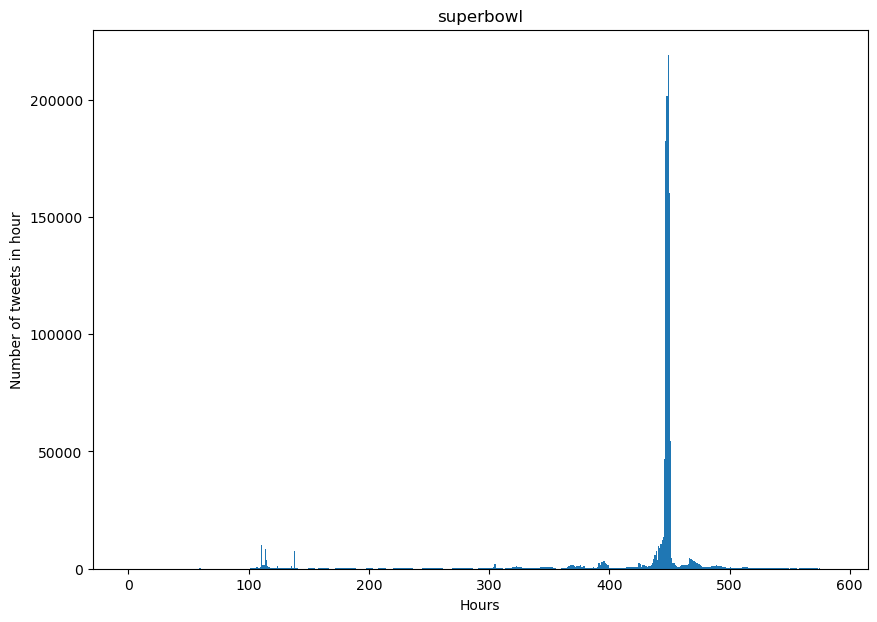

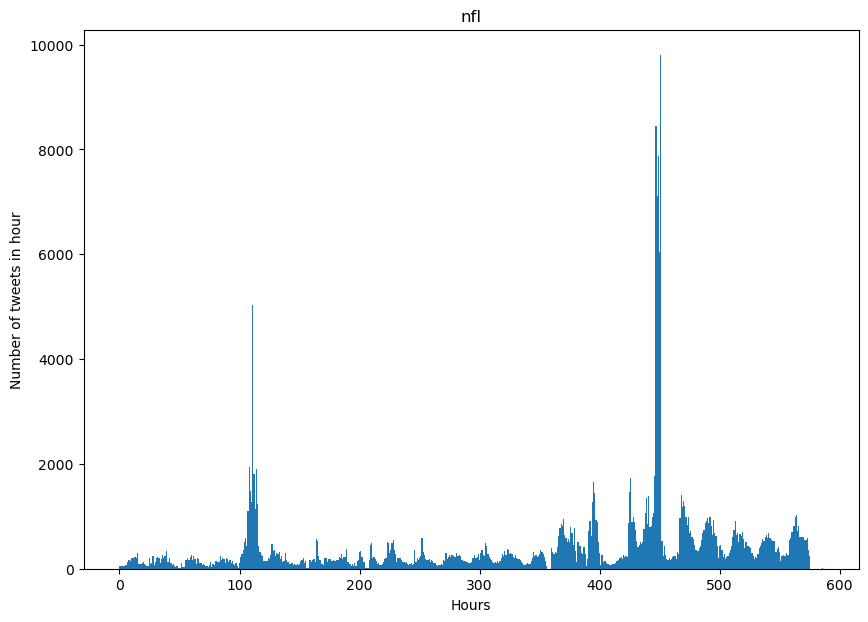

In [5]:
# Plot the bar graphs for average tweets in hour for Superbowl and NFL data
import datetime
for filename in ["superbowl", "nfl"]:
    with open(files[filename], 'r') as file:
        lines = file.readlines()
        hours = []
        for line in lines:
            hours.append(json.loads(line)['citation_date'])
        max_hours, min_hours = max(hours), min(hours)
        y = [0] * int((max_hours - min_hours) / 3600 + 1)
        for hour in hours:
            y[int((hour - min_hours) / 3600)] += 1
        x = range(len(y))
        print(datetime.datetime.fromtimestamp(min_hours), datetime.datetime.fromtimestamp(max_hours))
        # x = pd.date_range(datetime.datetime.fromtimestamp(min_hours), 
        #                   datetime.datetime.fromtimestamp(max_hours),
        #                   len(y)
        #                   )

        plt.figure(figsize=(10,7))
        plt.bar(x, y, 1)
        plt.xlabel("Hours")
        plt.ylabel("Number of tweets in hour")
        plt.title(filename)

# Question 10

In [6]:
with open(files["gohawks"], 'r') as file:
    lines = file.readlines()
    for i in range(10):
        object = json.loads(lines[i])
        print(json.dumps(object, indent=2))

{
  "firstpost_date": 1419804875,
  "title": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
  "url": "http://twitter.com/Mich_Fit/status/549327579782840320",
  "tweet": {
    "contributors": null,
    "truncated": false,
    "text": "I &lt;3 our defense! #GoHawks http://t.co/U1pcXpEsR8",
    "in_reply_to_status_id": null,
    "id": 549327579782840320,
    "favorite_count": 1,
    "source": "<a href=\"http://twitter.com\" rel=\"nofollow\">Twitter Web Client</a>",
    "retweeted": false,
    "coordinates": null,
    "entities": {
      "symbols": [],
      "media": [
        {
          "expanded_url": "http://twitter.com/Mich_Fit/status/549327579782840320/photo/1",
          "sizes": {
            "large": {
              "h": 511,
              "resize": "fit",
              "w": 511
            },
            "small": {
              "h": 340,
              "resize": "fit",
              "w": 340
            },
            "medium": {
              "h": 511,
              "re

In [170]:
def clean(text):
    text = re.sub(r'https?://\S+', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub('[\d]', '', texter)  # by gyf, remove numbers
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = "".join([ch for ch in texter if ch not in string.punctuation])
    if texter == "":
        texter = ""
    return texter


def get_pos(tag):  # get the property of a word from the pos_tag results
    if tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatization(text):
    wnl = WordNetLemmatizer()
    words = word_tokenize(text)  # divide the words of each data point
    tags = pos_tag(words)  # return the property of each word
    lemma = []
    for tag in tags:
        pos = get_pos(tag[1])
        lemma.append(wnl.lemmatize(tag[0], pos).lower())  # do the lemmatization
    return ' '.join(lemma)

def clean_and_lemmatize(tweet):
  tweet = clean(tweet)
  tweet = lemmatization(tweet)
  return tweet

def extract_hashtags_and_filtered_tweet(tweet):
    filtered_words = []
    hashtags = []
    for word in tweet.split():
        if word[0] == '#':
            hashtag = word[1:]
            clean_hashtag = clean(hashtag)
            clean_hashtag = clean_hashtag.lower()
            hashtags.append(clean_hashtag)
        else:
            filtered_words.append(word)
    clean_tweet = " ".join(filtered_words)
    return hashtags, clean_and_lemmatize(clean_tweet)

In [171]:
def extract_tweet_data_part_1(pats_filename, hawks_filename):
  # features required: tweet text, user follower count, timestamp, team (fanbase)
  # target: number of likes
  df = pd.DataFrame(columns = ['Text', 'Clean Text', 'Team'])

  with open(pats_filename, encoding = "UTF-8") as file:
    while True:
      tweet = file.readline()
        
      # reached end of file
      if not tweet:
        break
      
      tweet_json = json.loads(tweet)
      if (tweet_json['tweet']['lang'] != 'en'):
        continue
      tweet_hashtags, tweet_clean = extract_hashtags_and_filtered_tweet(tweet_json['tweet']['text'])
      tweet_text = clean_and_lemmatize(tweet_json['tweet']['text'])
      
      df = df.append({'Text': tweet_text, 'Clean Text': tweet_clean, 'Team': PATS}, ignore_index = True)
  
  with open(hawks_filename, encoding = "UTF-8") as file:
    while True:
      tweet = file.readline()
        
      # reached end of file
      if not tweet:
        break
        
      tweet_json = json.loads(tweet)
      if (tweet_json['tweet']['lang'] != 'en'):
        continue
      tweet_hashtags, tweet_clean = extract_hashtags_and_filtered_tweet(tweet_json['tweet']['text'])
      tweet_text = clean_and_lemmatize(tweet_json['tweet']['text'])
      
      df = df.append({'Text': tweet_text, 'Clean Text': tweet_clean, 'Team': HAWKS}, ignore_index = True)
  return df

In [172]:
df = extract_tweet_data_part_1(files["gopatriots"], files["gohawks"])
df.to_csv("df_part_1.csv")

In [173]:
df = pd.read_csv('df_part_1.csv')
print(df)

        Unnamed: 0                                               Text  \
0                0  legarrette blount do the ray lewis dance throw...   
1                1  with both my father and husband yelling at the...   
2                2  the girl soccer team be rank the no team in th...   
3                3  patriot patriots champions rt if you agree gop...   
4                4  the girl varsity soccer team dominate the firs...   
...            ...                                                ...   
155246      155246  how long to you think that it will be until we...   
155247      155247  seahawks all day everyday beastmode lob seattl...   
155248      155248  interview with the seattle seahawks superbowl ...   
155249      155249  if you love russell wilson and want to know mo...   
155250      155250  the ultimate broken hearted hangover week from...   

                                               Clean Text  Team  
0       legarrette blount do the ray lewis dance hope ...

## Model 1 (Using tweet content to predict team)
### Pre-processing (TF-IDF, SVD)

In [189]:
df1 = df

# randomize data as train_test_split will only pick last N datapoints as testing set
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df1.dropna(inplace=True)

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# split into train and test data
df_train, df_test = train_test_split(df1, test_size=0.25, random_state = 42)

# convert text into TFIDF vectors, reduced to 50 components using SVD
text_vec_pipeline = Pipeline([('convector', CountVectorizer(stop_words='english', min_df=3)), ('tfidf', TfidfTransformer()), ('dim_reduce', TruncatedSVD(50, random_state=42))])

df_train['TFIDF'] = text_vec_pipeline.fit_transform(df_train['Text']).tolist()
df_test['TFIDF'] = text_vec_pipeline.transform(df_test['Text']).tolist()

In [191]:
print(df_train['TFIDF'])

109139    [0.10585798622687939, -0.030891180112083638, -...
65294     [0.05485671026161267, -0.0198517700672743, -0....
7205      [0.19748475710372765, -0.05632427398164747, -0...
111578    [0.09456219465911102, -0.03162629345905243, -0...
131265    [0.13258781956899884, -0.03834265370743656, -0...
                                ...                        
119933    [0.06277402169544469, -0.01122279817102018, 0....
103745    [0.0560828156137688, -0.011753986139153814, 0....
131992    [0.11080330747556087, -0.029760871864968143, -...
146934    [0.10990940440379295, 0.01197324646579443, 0.0...
122014    [0.1333170790474995, -0.024969414575363967, 0....
Name: TFIDF, Length: 116385, dtype: object


In [192]:
X_train = np.stack(df_train.apply(lambda row: np.concatenate([row['TFIDF']]), axis=1))
y_train = df_train[['Team']].values.ravel()

X_test = np.stack(df_test.apply(lambda row: np.concatenate([row['TFIDF']]), axis=1))
y_test = df_test[['Team']].values.ravel()

In [193]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(116385, 50)
(116385,)
(38795, 50)
(38795,)


### Logistic Regression

In [194]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LogisticRegression(penalty='l1', C=100, solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

MSE:  0.0016239206083258151
R2:  0.9786879513959883


### Linear SVC

In [195]:
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error

svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

y_test_pred = svc.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

MSE:  0.0018301327490656012
R2:  0.9759816595097646


### Random Forest Classifier

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# Create a random forest regression model
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2, n_jobs = -1)

# Train the model on X_train and y_train
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s


building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


## Model 2 (Using tweet content with its hashtags filtered)
### Pre-processing (TF-IDF, SVD)

In [197]:
df1 = df

# randomize data as train_test_split will only pick last N datapoints as testing set
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)
df1.dropna(inplace=True)

In [198]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

# split into train and test data
df_train, df_test = train_test_split(df1, test_size=0.25, random_state = 42)

# convert text into TFIDF vectors, reduced to 50 components using SVD
text_vec_pipeline = Pipeline([('convector', CountVectorizer(stop_words='english', min_df=3)), ('tfidf', TfidfTransformer()), ('dim_reduce', TruncatedSVD(50, random_state=42))])

df_train['TFIDF'] = text_vec_pipeline.fit_transform(df_train['Clean Text']).tolist()
df_test['TFIDF'] = text_vec_pipeline.transform(df_test['Clean Text']).tolist()

In [199]:
X_train = np.stack(df_train.apply(lambda row: np.concatenate([row['TFIDF']]), axis=1))
y_train = df_train[['Team']].values.ravel()

X_test = np.stack(df_test.apply(lambda row: np.concatenate([row['TFIDF']]), axis=1))
y_test = df_test[['Team']].values.ravel()

In [200]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(116385, 50)
(116385,)
(38795, 50)
(38795,)


### Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

lr = LogisticRegression(penalty='l1', C=100, solver='liblinear', random_state=42)
lr.fit(X_train, y_train)

y_test_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

MSE:  0.07993298105425957
R2:  -0.04902639239746476


### Linear SVC

In [202]:
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error

svc = LinearSVC(random_state=42)
svc.fit(X_train, y_train)

y_test_pred = svc.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

MSE:  0.08088671220518108
R2:  -0.06154299237124938


### Random Forest Classifier

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# Create a random forest regression model
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=2, n_jobs = -1)

# Train the model on X_train and y_train
rf.fit(X_train, y_train)

y_test_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
print("MSE: ", mse)
print("R2: ", r2)

building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.6s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.1s finished
